In the Week 4 the instructor is mainly speaking about metrics for evaluating how good a model is, and their drawbacks. By the names of the videos I can see that it is going to be mainly about classification metrics, since I'm already familiar with them. 

We will start off by importing necessary libraries and put the code necesarry just for training the model on which we obtained accuracy of 80%. Refer to details in ```validation-framework.ipynb```. 

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from collections import Counter

In [2]:
#Data munging is already done, and the data is extracted in 'data-preparation.csv' 
#so I will just import the already prepared data.

RANDOM_STATE = 42
df = pd.read_csv('./data/data-preparation.csv')

df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [3]:
#Splitting the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=RANDOM_STATE)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [4]:
#Assesing categorical vs numerical variables
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

I think here it is worth mentioning that in the previous notebook we've trained on ```df_train_full``` at the very end, but that is the step AFTER tuning our model on validation data and since validation data is used for assesing model performance (as I call it *playground*) we have to take a step back in the Data Science process and work from there. 

That is why we are training on ```df_train```. 

In [5]:
#Preparing the data for model by doing OHE...
dv = DictVectorizer(sparse=False)

#...and training the Logistic Regression model
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Remember, last time that we spoke a bit on *cut-off probability*. Once the model learned weights and bias term we gave it validation data as input and obtained probabilities that the model infered on that data.

We said explicitly that cut-off probability is 0.5 (which is a default one for Logistic Regression) and we said that everything above that probability will be considered as **customer will churn** (we will put 1 there), while conversely everything lower than that would mean **the customer wont churn** (we will put 0 there).
And, we obtained those *hard predictions* and put them in a NumPy array ```churn_decision```. 

Here is the code for that:

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)

In [7]:
type(churn_decision)

numpy.ndarray

So, what are the potential drawbacks on this? Well, we are lucky enough to know there are ground truths for churning in the validation data (```y_val```), and we can compare them with the 'hard predictions' we assesed using 0.5 as a cut-off probability (```churn_decision```). Pay close attention to **compare them**. 

Don't fall into trap thinking 'it is only for churned customers'. No, by using 0.5 as a cut-off probability we are also assesing predictions for the customers that didn't churn. We don't want model to just predict good on those who will churn, or only on those who wont. We want a well-rounded model. We put the money in knowing that model as *a decision maker* will serve us well for both. I want to send a promotional email for those who are willing to churn, not loose money on those who wont. They are satisfied! 

Here is a DataFrame I've created previously to get a better picture of what I'm trying to say:

In [8]:
#Creating a dataframe containing all the info we need
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['actual'] = y_val
df_pred['prediction'] = churn_decision.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

df_pred.tail(10)

,probability,actual,prediction,correct
1399,0.070878,0,0,True
1400,0.681527,1,1,True
1401,0.629268,0,1,False
1402,0.035397,0,0,True
1403,0.060248,0,0,True
1404,0.067729,1,0,False
1405,0.315531,0,0,True
1406,0.713464,1,1,True
1407,0.050559,0,0,True
1408,0.036023,0,0,True


So, given a cut-off probability of 0.5, here is how accurate our model is on assesing both customers who will and those who won't churn:

In [9]:
df_pred.correct.mean()

0.8034066713981547

We see that there are mistakes, and the model is mistaking only 20% of a time. Here is a filtered DataFrame for mistakes only.

In [10]:
df_pred[df_pred['correct'] == False].head(10)

,probability,actual,prediction,correct
2,0.435661,1,0,False
10,0.629899,0,1,False
13,0.569593,0,1,False
15,0.704182,0,1,False
16,0.665806,0,1,False
20,0.165914,1,0,False
26,0.508863,0,1,False
29,0.183885,1,0,False
32,0.170327,1,0,False
34,0.046092,1,0,False


Imagine for a moment what would happen on these 10 rows of data if we said that the cut-off probability is >=0.2. How many of them would be **now** correctly classified by our model? Now play with that idea and think what would happen if we changed ```churn_decision = (y_pred >= 0.5)``` to ```churn_decision = (y_pred >= 0.1)``` on **the whole validation dataset** not just this sample of 10 rows? What would be the accuracy? Think of the edge cases 'what if we said cut-off to be >=0, >0, >=1'? Now, play with the different values of cut-off frequency and asses the accuracy. 

This will also teach you how to explore/tweak the code already written, how to start small and work your way up to a generalization. I think it is also a very useful skill to have under your belt!

Finally, you will realize *'There has to be a better way instead of playing with them. I know maths. I know how to visualize graphs.'*

In [11]:
thresholds = [round(element, 3) for element in np.linspace(0, 1, 21)]

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(round(score,4))

thr_accuracy_dict = dict(zip(thresholds, scores))

thr_with_max_accuracy = max(thr_accuracy_dict, key=thr_accuracy_dict.get)

In [12]:
def plotting_threshold_vs_accuracy(cut_off = thr_with_max_accuracy):    
    '''
        By default it will graph threshold vs accuracy and the point of inflection will be seen as two lines
        (horizontal and vertical) intercepting. That is the point where the threshold gives best accuracy score.

    '''
    # Plotting the graph
    plt.plot(thresholds, scores, label='Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')

    # Add a vertical line at a specific threshold (for example, threshold=0.5)
    plt.axvline(x=cut_off, color='red', linestyle='--', label=f'Threshold = {cut_off}')
    plt.legend()

    # Add a horizontal line at the accuracy value corresponding to the chosen threshold
    chosen_accuracy = accuracy_score(y_val, y_pred >= cut_off)
    plt.axhline(y=chosen_accuracy, color='green', linestyle='--', label=f'Accuracy = {chosen_accuracy:.4f}')
    plt.legend()

    # Show the plot
    return plt.show()

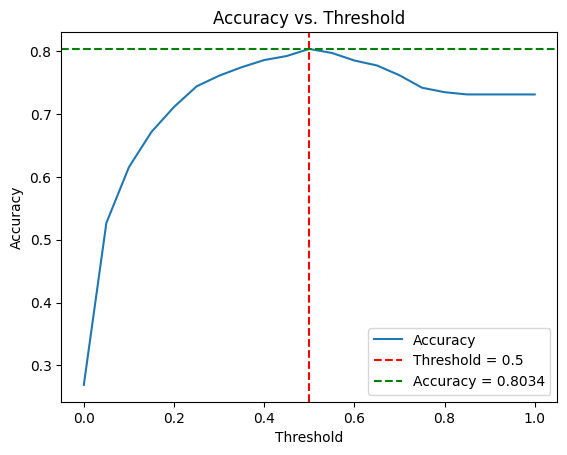

In [13]:
plotting_threshold_vs_accuracy()

We could eyeball that the accuracy score is the best around ```cut-off == 0.5``` and in the words of instructor *'```LogisticRegression()``` is optimizing for that cut-off already'*, but it is never bad to check it either via graph to get a representation of *all* the possibilities or like we've done it via code.

---

Now comes the concept of *Dummy Model*. Why would it be called *dummy*? Here is my interpretation of it. 

Apart from point on an x-axis (threshold) that gives us best accuracy score, there exist two more points that have much of an interest for us. Those are points where ```threshold = 1``` and ```threshold = 0```.

Think what would mean if we said 'for all the probability predictions where ```probability = cut_off >= 1``` say that customer churned'. I rarely saw that model is so damn sure about a prediction, and even if it is the case sigmoid is asympthotically aproaching 1. Could be due to very unlikely event, or synthetically putting row which for given weights and bias gives the result close to 1. 

But even without that, given that ```cut-off=1``` then model predicts that all people never churned, because all other probabilities are <=1. Do you think the accuracy would be 0? Let's take a look!

In [14]:
churn_decision = (y_pred >= 1)
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['actual'] = y_val
df_pred['prediction'] = churn_decision.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

df_pred.head(10)

,probability,actual,prediction,correct
0,0.167199,0,0,True
1,0.253132,0,0,True
2,0.435661,1,0,False
3,0.562363,1,0,False
4,0.049742,0,0,True
5,0.125869,0,0,True
6,0.377995,0,0,True
7,0.013390,0,0,True
8,0.063902,0,0,True
9,0.147764,0,0,True


No, it would give the accuracy of 73%, because 73% of our validation data has **actual value** of ```churn == 0``` (Remember, we are calculating mean on the ```correct``` column!). 
73% of our validation dataset contains people that didn't churned, and 100%-73%=27% is the percentage of people who actually churned. 

In [15]:
df_pred.correct.mean()

0.7310149041873669

Why would we ever use a model which for every input predicts that nobody will churn? That model would never find out those who WILL potentially churn and we need to keep them and send them a promotional email! Why would we even bother training a model for such matter in a first place? We could make a decision 'nobody will churn, just relax and chill'. But, what is the point in that? 

That is why it is called *a Dummy Model*. We could done everything without ever using ML. 

But another question arises, why would we train the best model which gives us 80% accuracy, but a 'dummy model' gives us accuracy of 73% which is 7% in difference? That is why the accuracy metric is not so good with assesing imbalanced datasets. If we had balanced dataset (50% churn, 50% no churn) then the difference between model who gives accuracy of 80% and *dummy model* who gives 50% would be significant!

Dummy model of 'predicting that no customer will churn' is even better than Random Classifier which you can imagine as one which for each row in a dataset will toss a fair coin and decide if the customer would churn (heads) of not (tails). After you finish with all the coin tosses you will see that Random Classifier still gives around ~50% churned and ~50% didn't churned. 

Let's do some basic stats experiment to test that assumption!

In [16]:
import random


def coin_toss(weight_heads, weight_tails):
    
    '''
        Define a coin_toss function which will serve us as a proxy for tossing the real one.
    '''
    
    # Define the choices and their weights
    choices = ['Heads', 'Tails']
    weights = [weight_heads, weight_tails]
    
    # Perform the coin toss
    result = random.choices(choices, weights)[0]
    
    return result

In [17]:
#Let's test our function by setting the weights for 'Heads' and 'Tails' to be a fair toss
weight_heads = 50
weight_tails = 50

#Perform a simple coin toss
toss_result = coin_toss(weight_heads, weight_tails)

#Print the result
print(f"The result of the coin toss is: {toss_result}.")

The result of the coin toss is: Tails.


Now, we will strip the ```df_pred``` which contains all the predictions for validation dataset and it's actual values. We only need ```probability``` and ```actual``` as columns.

In [18]:
df_coin_toss = df_pred[['probability', 'actual']].copy()
df_coin_toss.head()

,probability,actual
0,0.167199,0
1,0.253132,0
2,0.435661,1
3,0.562363,1
4,0.049742,0


Next, we are going to use ```coin_toss``` function which will for each row artificially toss a coin and populate the column ```coin_toss_result``` with either 'Heads' or 'Tails'. 
Then we are going to create a new column ```is_heads``` which will give us 1 if the result is 'Heads' or 0 if the result is 'Tails'. It will serve us in such a way that we can compare the results with the column ```actual``` like we did similarly whilst defining the cut-off probability.

Finally, we are going to compare ```actual``` with ```is_heads```.

In [19]:
df_coin_toss['coin_toss_result'] = df_coin_toss.apply(lambda row: coin_toss(weight_heads=50, weight_tails=50), axis=1)
df_coin_toss['is_heads'] = df_coin_toss['coin_toss_result'].apply(lambda result: 1 if result == 'Heads' else 0)
df_coin_toss['correct'] = df_coin_toss.actual == df_coin_toss.is_heads

In [20]:
df_coin_toss.head()

,probability,actual,coin_toss_result,is_heads,correct
0,0.167199,0,Heads,1,False
1,0.253132,0,Tails,0,True
2,0.435661,1,Tails,0,False
3,0.562363,1,Tails,0,False
4,0.049742,0,Tails,0,True


Now, a random process is a random process so don't expect to have exact 50% of 'Heads' and 'Tails'.

Here is the 'accuracy' of our Random Classifier:

In [21]:
df_coin_toss.correct.mean()

0.5060326472675657

Finally, let's *prove* that on average you should obtain nearly 50% for such result.

In [22]:
results = []
no_of_runs = 100

for i in range(no_of_runs):
    
    ##### This is our experiment
    df_coin_toss['coin_toss_result'] = df_coin_toss.apply(lambda row: coin_toss(weight_heads=50, weight_tails=50), axis=1)
    df_coin_toss['is_heads'] = df_coin_toss['coin_toss_result'].apply(lambda result: 1 if result == 'Heads' else 0)
    df_coin_toss['correct'] = df_coin_toss.actual == df_coin_toss.is_heads
    #####
    
    results.append(df_coin_toss.correct.mean())
    
print(f'Here is the average: {round(np.mean(results),4)}.')

Here is the average: 0.4996.


Increase the number of times this experiment runs by modifying ```no_of_runs``` and it will asymtotically get to 50%.

---

What about a model that has ```cut-off>=0```? Well, think of it. We have an unbalanced dataset with 27% of customers that churned. If we predicted that everyone churned, then we would be right only 27% of time. That is also the lowest possible accuracy we can have. Yes, we found all the True Positives but think of giving 73% of people email promotion of 25% discount. It is not going to impress your CEO at all. The model is even worse than previously discussed Random Classifier, and it could also be a decision which doesn't need ML at all. 

# Precision and Recall

We've seen that accuracy could be misleading when it comes to a model which deals with unbalanced dataset. We've also seen that some *new* problems came into focus when we changed the threshold. Not only it impacted accuracy, but changing it introduced the idea of different *errors in predictions*. We saw the effects of those errors when we introduced ```Dummy Model(s)``` and ```Random Classifier```. Now we will define them explicitly, and put them into the context of other metrics. 

Those metrics can be derived for the very same model and apart from accuracy will give you even better perspective on model's *quality*.

Always bear in mind that our initial objective was to identify individuals who have churned, and we intend for them to be a primary focus without exclusively limiting our attention to other problems. 

---

I know I am putting cart before the horse here but if I started all over again I would first introduce the main ideas of some metrics via a bit of storytelling, and then derive them step-by-step as instructor did in his video. 

Let's pretend that our model is some kind of entity (ex. robot) where it has three abilities: 

1) ability to predict of who is going to churn, 

2) ability to recall information,

3) ability of being precise. 

We've trained the robot and now we asses her performance on these abilities presented. We will test her on a validation dataset because we know the actual values and because it serves for model calibration. We let her tell us the predictions, and from there we asses **Precision** and **Recall**.

In what context would you define the idea of a robot 'being precise' when it comes to sending a promotional emails to those customers who are going to churn? 

I would say, out of all those people who she **predicted** that are going to churn she **would be** *precise* for *some* amount/percentage of them. Some of them didn't want to churn at all, but hey, she **wanted** to send them promotional emails anyways! Those would be **<span style="color:red">misses</span>**, and we would lose the money because of those mistakes, since those customers would take an advantage of promotion. The other ones are  **the real ones** and we really should send those a promotional email. If we let her to take an action of sending the emails, then those would be **<span style="color:green">on target</span>**. But, how much she would be *precise*? 

Well here is how you would calculate it:

\begin{equation}
\frac{\color{green}{\text{People who are truly going to churn and she correctly predicted that}}}{\color{green}{\text{People who are truly going to churn and she correctly predicted that}} \text{ AND } \color{red}{\text{People who were falsely predicted to churn but in reality they didn't want}}}
\end{equation}

The denominator represents ***the set of all people who robot predicted that are going to churn***. The emphasize is on **predicted all those who will potentially churn**. Are there mistakes? How much she is *precise* after all? We will see in the code below. 

The main focus of the **Precision** as metric is 'how precise we **were** at sending those emails'. So, the focus is on "one step ahead", imagining the robot already took an action of sending an email to all those  predicted as churning customers. After the imaginary action was taken, we are assesing the quality of how precise it is via **Precision score**. 

In other words, it focuses on the question 'imagine that we gave her power to take that action, how many of them we would send the emails and we hit the target?' and 'how many of them would mistakingly get an email in their inbox and use the advantage of discount?'.

I'm pointing this all out because, on the other hand, introducing the idea of *robot's ability to recall information* could be confusing since it is quite similar metric. But, there is a very subtle difference! 

Think of **Recall** as robot's 'state of being', her 'memory capabilities', her 'ability to recall information without any action previously taken'. 

So, we first start training her, and now it is time to give her memory a test. We gave her a validation dataset of customers who churn, we gave her a little time to think about it (find a way to memorize them) and she gave us the ```y_preds``` after some time. It comes at an instant (no big surprise!) but **<span style="color:green">how much of them she memorized correctly</span>**? **<span style="color:red">How much of them she forgot?</span>** How would we asses her ability of recalling information? 

\begin{equation}
\frac{\color{green}{\text{People who she recalled correctly that are going to churn}}}{\color{green}{\text{People who she recalled correctly that are going to churn}} \text{ AND } \color{red}{\text{People who we KNEW that are going to churn but she FORGOT them}}}
\end{equation}

In other words, it focuses on the questions of 'how many of churning customers we've **identified** correctly' and 'how many of them we **failed to identify**'.

Really take time to pause and ponder a bit on what is the main focus of **Precision**, and what is the main focus of **Recall**. They seem similar, but you have to shift a perspective to fully grasp them. 


---

'Well, how about introducing the other cut-off probabilities? Will it change the robot's **Precision** and **Recall**?'

To answer those questions we must first introduce the idea of **confusion matrix**, and actually calculate **Precision** and **Recall**. 

# Confusion Matrix

It is a silly analogy but I think of **confusion matrix** as **'table that shows us what the model is doing right, and what it confuses'**. In some sense it gives us even more 'under the hood of model' kind of informations.

If you are rusty on understanding True Positives, True Negatives, False Positives and False Negatives I strongly suggest you to watch the videos for Week 4, because instructor explains it perfectly with a lot of visualizations to help you with the understanding.


We gave a pre-trained model a validation dataset, and the model gave us predictions. No matter which cut-off probability we choose we can interpret those predictions as follows:

**True Positives** (TPs) - The actual value we input to a model is 'churn' or 1 and it predicted it correctly as 'churn', which is 1,

**True Negatives** (TNs) - The actual value we input to a model is 'no churn' or 0 and it predicted it correctly as 'no churn' which is 0,

**False Positives** (FPs) - The actual value we input to a model is  'no churn' or 0 and it wrongly predicted that it is 'churn' which is 1. Those are the ones which model confuses, and they are giving us 'false sense that someone is churning, while in reality he is not and he will use the advantage of a promotion'. 

**False Negatives** (FNs) - The actual value we input to a model is 'churn' or 1 and it wrongly predicte that it is 'no churn' which is 0. Model confuses those aswel, and they are giving us 'false sense that somebody is not going to churn, but we should have sent him an email! We lost him!'. 

--- 

We will first stat with the cut-off probability (refered as threshold) of 0.5, and slowly introduce the idea of what may happen for Accuracy, Precision and Recall if we change it. 

In [23]:
t = 0.5 # Cut-off probability/Threshold

actual_positives = (y_val == 1)
actual_negatives = (y_val == 0)

predicted_positives = (y_pred >= t)
predicted_negatives = (y_pred < t)

tp = (predicted_positives & actual_positives).sum()
tn = (predicted_negatives & actual_negatives).sum()

fp = (predicted_positives & actual_negatives).sum()
fn = (predicted_negatives & actual_positives).sum()

In [24]:
#Let's define the confusion matrix and put organise those into one table
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[927, 103],
       [174, 205]])

In [25]:
#Let's normalize the confusion matrix and see those as percentages in overall dataset

(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

Let's bring back for a moment definitions of Precision and Recall to understand them in terms of TPs, FPs and FNs:

## Precision
\begin{equation}
\frac{\color{green}{\text{People who are truly going to churn and she correctly predicted that}}}{\color{green}{\text{People who are truly going to churn and she correctly predicted that}} \text{ AND } \color{red}{\text{People who were falsely predicted to churn but in reality they didn't want}}}
\end{equation}

Given all the people/customers who are truly going to churn (```actual values``` from validation dataset) how many of them model correctly predicted as churning (```predicted values``` that model spits out)? Those are **<span style="color:green">True Positives</span>**. The model got those right.

On the other hand, you just have to flip this sentence 'People who were falsely predicted to churn but in reality they didn't want' into 'People who in reality (```actual values``` from validation dataset) didn't plan to churn were predicted (```predicted values``` that model spits out) as if they are going to churn, which is false', how many of them are there? Those are **<span style="color:red">False Positives</span>**. The model confused those. 

\begin{equation}
\text{Precision} = \frac{\color{green}{\text{True Positives}}}{\color{green}{\text{True Positives}} + \color{red}{\text{False Positives}}}
\end{equation}



## Recall 
\begin{equation}
\frac{\color{green}{\text{People who she recalled correctly that are going to churn}}}{\color{green}{\text{People who she recalled correctly that are going to churn}} \text{ AND } \color{red}{\text{People who we KNEW that are going to churn but she FORGOT them}}}
\end{equation}

'People who she recalled correctly that are going to churn can be translated to 'given all the people who are churning (```actual values```) how much of them she 'recalled' (predicted) correctly?'. Again, if you think about it, those are **<span style="color:green">True Positives</span>** but just expressed in a different context because of the meaning **Recall** is presenting. If we gave a model actual value of 1 (churning customer), and the model predicted it as one then it means that the model remembered that fella! 

'People who we KNEW that are going to churn but she FORGOT them.' Well, the model/robot is not ideal, and we gave it sequence of churning customers (```actual values```), but some of them she forgot. How many? If you think about it, those she forgot are the ones that went sneakingly inside **<span style="color:red">False Negatives</span>**. Why? Because, they are actually 1s but the model mistakingly predicted them as 0s. In other words, they are still 1s, their actual values of churning is 1, but the model *forgot* them by thinking of them as 'non-churning ones'. She memorized them in a wrong way. 

\begin{equation}
\text{Recall} = \frac{\color{green}{\text{True Positives}}}{\color{green}{\text{True Positives}} + \color{red}{\text{False Negatives}}}
\end{equation}

> Imagine how many False Positives were killed in Matrix.

When in doubt, just give another look at 'what those metrics are focusing on' and with time they will feel second nature.

In [26]:
#Given threshold t == 0.5 here is the Precision...
precision_score = tp / (tp + fp)
precision_score

0.6655844155844156

In [27]:
#...and here is Recall
recall_score = tp / (tp + fn)
recall_score

0.5408970976253298

## Receiver Operating Characteristic (ROC) Curve

The idea of ROC curve is used in WW2 by radar detectors to asses how reliable radar detectors are in finding (enemy) planes. I would say that you can interpret it two ways:

1) Where True Positives represent 'enemy planes', while True Negatives represent "the non-enemy ones",

2) Where True Positives represent 'there is a plane in a sky", while True Negatives represent "there are no planes in the sky".

The first one intuitevely makes more sense, obviously, but you might encounter the version 2) in the wild so have that in mind! For this explanation I will use the second one, because that is the version that the instructor is explaining and I expect that somebody who wants notes for the Week 4  of this course expects this version also. 

This ROC idea uses all of what we've previously explained but it also extends the whole idea by using different cut-off probabilities. Thinking about 'Precision' and 'Recall' is one version of interpreting performance of a model, but this one is slightly different and it might confuse you at first by mixing them even if they use the same fundamentals. Thinking this way is what 'unstucked' me while I first encountered it.

---

So, you are in WW2 and given the 'confusion matrix' (I don't know if they used the very same terminology) and given that we want to asses detection of planes via radar you would be mainly interested in two metrics, **True Positive Rate** and **False Positive Rate**. 

Given their definitions you will see why it make sense. Let's say that we test our radar by simulating that there are enemy planes on the sky. We sent in the air some amount of planes and we want to see:

1) **True Positive Rate (TPR)** - How **sensitive** is our radar at detecting enemy planes? How many True Positives radar detected (we sent a plane in the air, detector said it is 'an enemy plane')? Some amount of planes were flying around, but the radar said 'it is a clear sky'. Those are False Negatives. The radar falsely assumes that there are no planes when in reality there are. I encourage you at this point to think about them as "we've sent an actual plane but somehow it got hidden to our radar", because you should count them also! Out of all planes we've sent (think of them as actual values), some of them True Positives and the other (hidden ones) False Negatives, we are interested in how many of True Positives we've actually detected:

\begin{equation}
\text{True Positive Rate} = \frac{\color{green}{\text{True Positives}}}{\color{green}{\text{True Positives}} + \color{red}{\text{False Negatives}}}
\end{equation}

Does it makes sense to define such a metric for testing reliability for radar? I think it does. Reminds you of something? **Recall**. But at that time it was coined as 'Sensitivity' and to me, at that time of WW2 it would make more sense to say 'how sensitive is our radar to detecting enemy planes' rather than 'how good is a radar at recalling that there are planes'. I don't think at that time electronics were that sophisticated and advanced so the radars became more focused on clever physics and electronics on 'sensing' the metal structure and calling it a plane (that is my blind guess!), whilst nowdays modern radars do probably use AI to detect planes and in a loosely defined sense it could be thought as 'object detection model that learned on the previous data' which could be then interpeted as Recall because using 'trained mode' could be thought as our 'robot analogy'. 


Oh, but we should also focus on False Positives! Here are several ways in which radar was used in conjunction with guns during this period:

>Early Warning Systems:
Radar was used as an early warning system to detect incoming enemy aircraft at a distance. This allowed defenders to prepare for incoming attacks and scramble aircraft or deploy anti-aircraft defenses.

>Target Tracking:
Radar technology improved over the course of the war, enabling more sophisticated target tracking. This was crucial for accurately predicting the movement of aircraft, especially in scenarios where they were evading anti-aircraft fire.

Think about having False Positives and how much they would cost whilst doing something like 'deploy anti-aircraft defenses' when there is nothing in the sky. Hence, they used False Positive Rate in conjuction with True Positive Rate to assses how reliable a radar is:

\begin{equation}
\text{False Positive Rate} = \frac{\color{green}{\text{False Positives}}}{\color{green}{\text{False Positives}} + \color{red}{\text{True Negatives}}}
\end{equation}


Out of all times that sky was clear, either actually clear (True Negatives) or falesly assumed that there was a plane while the sky was clear (False Positives) how many of those were false alarms (False Positives)?

Now you see why these two are the main ones when assesing how good is radar at detecting planes. Obiously, you would try to maximize True Positive Rate, while at the same time you would like as lowest False Positive Rate as possible. 

Take a look at the equation for the TPR. Increasing True Positive Rate would mean that you want to increase True Positives as much as you could, which has a direct consequence of decreasing False Negatives. Think of it 'if one False Negative gets out of the set of False Negatives it becomes True Positive'. So, at the extreme (ideal case), if every False Negative gets out of the set of all False Negatives then they will 'enter' the set of True Positives. Then the sensitivity is maximum. Why? Take a look at the equation. If number of elements in a set of False Negatives becomes 0 then we have a case:

\begin{equation}
\text{True Positive Rate} = \frac{\color{green}{\text{True Positives}}}{\color{green}{\text{True Positives}} + \color{red}{\text{False Negatives}}} = \frac{\color{green}{\text{True Positives}}}{\color{green}{\text{True Positives}} + \color{red}{\text{0}}} = \text{1}
\end{equation}

Think how False Positive Rate should get minimized. Now, we have to obviously decrease the amount of False Positives, and again each False Positive becomes True Negative once we start decreasing it. In an extreme (ideal case) this would hold:

\begin{equation}
\text{False Positive Rate} = \frac{\color{green}{\text{False Positives}}}{\color{green}{\text{False Positives}} + \color{red}{\text{True Negatives}}} = \frac{\color{green}{\text{0}}}{\color{green}{\text{0}} + \color{red}{\text{True Negatives}}} = 0
\end{equation}


> Sun Tzu would be proud. 

One would argue that FPR and TPR are mutually exclusive (just look at the terms in each equation!) but the model spits out probabilities and depending on the particular choice of cut-off probability you can influence ex. TPRs for good and at the same time make FPR worst. That is a trade-off. I would argue that the more accurate the model is at predicting realistic probabilitites the better your options will be when choosing cut-off probability and finding ideal TPR and FPR. 

What is a better way than visualizing for each cut-off probability TPR and FPR for that matter? That is the main point of a ROC curve. 

But, even without drawing ROC curve it should be fairly intuitive by now that given all the cut-off probabilitites you need to find the most divergent TPR vs FPR. Algorithmically, you should find a sweet spot where TPR is as higher as possible whilst FPR is as lower as possible. Later on you will see that those two are 'merged' into one graph (ROC curve) and you no longer search for that in the same fashion. Rather, you are looking at one point where TPR is highest and FPR lowest. 
 

---

Fast-forward to 'modern times'! We've discussed a fair amount of time on something which could be easily transfered to assesing performance of classifiers. Instead of detecting planes, our True Positives are 'people that actualy churn and we predicted them as churn', whilst False Positives are what we should minimize at all cost. Let's translate all of this to code.

In [28]:
#Define True Positive Rate (cut-off == 0.5)
tpr = tp / (tp + fn)
tpr

0.5408970976253298

In [29]:
#Define False Positive Rate (cut-off == 0.5)
fpr = fp / (fp + tn)
fpr

0.1

In [30]:
#Define all possible Confusion Matrices for each threshold

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [31]:
#Define a new DataFrame for holding all those information
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

#Add columns for True Positive Rate and True Negative Rate
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

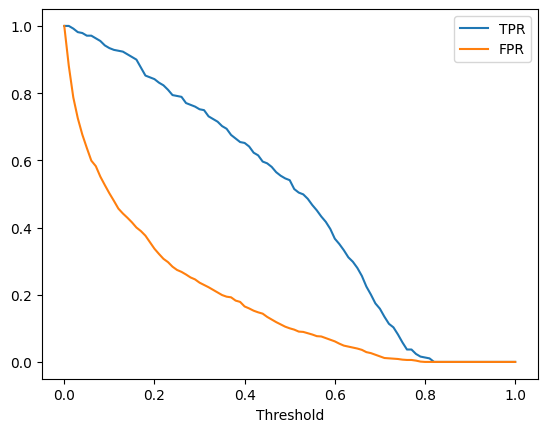

In [32]:
#Finally, let's draw for each threshold all TPRs an FPRs

plt.xlabel('Threshold')

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend();

Some of the stuff here could be only 'eyeballed' when it comes to choosing 'ideal TPR/FPR'. Keep in mind that how good the predicted probabilities are and the more of such we have, the more you are getting towards an ideal model which could be found via some cut-off probability. Given this visualization we see that intuitevely if we wanted better TPR then graph for TPR should be more inclined towards higher values (strive for hitting that upper right corner), whilst graph for FPR should be more inclined towards lower points (strive for hitting that down left corner). That would give us an opportunity for finding (even) higher TPR and lower FPR. 

In reality, you would first strive for finding a model that makes such thing the case (AUC score is used for comparison, but more on that later!) and when you finally exausted and found an *ideal* model you would define desired TPR and desired FPR which would be tolerable. ML is not a magic bullet. 

---

Two points on this graph should also be of an interest because it would give you better picture in head of how changing threshold might influence TPs, FPs etc. and I strongly encourage you to do so. It will give you better intuition about all of this. 

The first one is when threshold>=0. In terms of TPR and FPR, what would happen? First, you are predicting that everyone is churning and it is a dummy model. You would cover all True Positives since no matter what the predicted probability is you would treat them as churn. At the same time, there wont be any False Negatives, because for each actual 'churn' you would predict 'churn' so there is no space to make any mistake since False Negatives are "actual churn predicted as no churn". Given threshold>=0 it can't happen. So, with a bit of math you would come to a conclusion that ```TPR==1```. 

How about FPR? Seems counter-intuitive at first that it should be 1, but again, think about it. By saying that everybody is churning then for each customer that is not churning you are predicting that he/she is. Those are all False Positives. If all of them are false positives then there is no space for predicting True Negatives, because you've just covered all of them! Again, you would come up to ```FPR==1```. 


The second point is when the threshold>=1. Without looking at the graph imagine what would happen if you define a ```DummyModel``` for which 'predict all as non-churning' (there is no way that a model is 100% sure someone will churn and every predicted probability will be at most smaller than 1). Two things happen when for each actual value of churn we are predicting no churn: all the True Positives are lost, and if you remembered when I said that "for each True Positive we lose from a set, a new False Negative appears" then all of those are False Positives. Hence, ```TPR==0```. Similarly, for each customer that is non-churning we are predicting that, indeed, he/she wont churn. We increase True Negatives to a maximum, and all False Positives are lost.

**Note: On the visualisation you will see start to see the same behaviour after ~0.83 threshold, but again 'blame the model' for giving such a set of predicted probabilities where it is the case that ```TPR==FPR==0``` given any threshold above 0.83.**

## Ideal Model

Obviously, not only that we need to look our model for each possible threshold but also we need something to compare our model with. There are two extreme cases to be look upon. The first one is 'ideal model' and the second one is 'random classifier'. We will discuss the second one right after. because building intuition about this will give you a better picture why Random Classifier has that 'diagonal line' where ```TPRs``` follow ```FPRs```. 

How would the ideal model look like on our ROC visualization? Well, first of all, in the ideal case we expect ```TPR==1``` and ```FPR==0```. Do you think that ideal model should be 'ideal' for each threshold? I can think of two cases:

1) You can make it synthetically good for a particular cut-off which will never happen,

2) You can make it closely ideal by introducing something that might resemble 'ideal' predicted probabilities.

In the first case you can get any threshold to work (or the range of thresholds!). Say you want ```threshold>=0.43```. No problem, just make sure that all probabilities for non-churning customers are less than that, and for the churning ones make it more than that. 

Here is the code:

In [33]:
#Define the utility function for creating DataFrames for comparing TPRs and FPRs

def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [34]:
#Let's create a DataFrame which has same number of churning and non-churning customers like the original one
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

#First we will repeat 0 num_neg times, and then we will repeat 1 with num_pos times
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [35]:
#Then we will create something that resembles our case when t>=0.43
y_ideal_pred = np.repeat([0.429, 0.434], [num_neg, num_pos])
y_ideal_pred

array([0.429, 0.429, 0.429, ..., 0.434, 0.434, 0.434])

In [36]:
#Finally, let's generate all the scores based on that:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,379,1030,0,0,1.0,1.0
10,0.1,379,1030,0,0,1.0,1.0
20,0.2,379,1030,0,0,1.0,1.0
30,0.3,379,1030,0,0,1.0,1.0
40,0.4,379,1030,0,0,1.0,1.0
50,0.5,0,0,379,1030,0.0,0.0
60,0.6,0,0,379,1030,0.0,0.0
70,0.7,0,0,379,1030,0.0,0.0
80,0.8,0,0,379,1030,0.0,0.0
90,0.9,0,0,379,1030,0.0,0.0


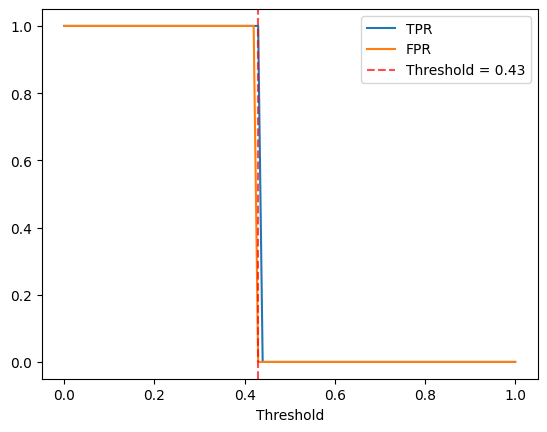

In [37]:
#Let's turn all that to be more visual

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')

plt.axvline(x=0.43, color='red', linestyle='--', alpha = 0.7, label=f'Threshold = {0.43}')
plt.xlabel('Threshold')

    
plt.legend();

Only in that small increment of thresholds the model would be ideal (but, think it as 0.43!) , where ```TPR==1``` and ```FPR==0```. But, one would never obtain a model which produces such probabilities that is why it is more 'synthetic'. 

However in the second case, even if it is also synthetic in nature, it will resemble at least more realistic (but non-probable) example of what model could produce. We need something that will serve us as a proxy for producing probabilities and hence ```np.linspace(0, 1, len(y_val))``` is used. It will produce 'progressively increasing probabilities' in linear fashion. It will also introduce different versions of ```TPR``` and ```FPR``` but, at the same time, it will have (undoubtly) a cut-off probability around ```0.7```. But, why is that? Think of it, the probabilitites produced by ```linspace``` would start from 0 and get up to 1, progressively increasing and we would first generate all non-churning customers which follows portion of churning ones. What cut-off would satisfy that? Well, since there are around 70% of non-churning ones, then if you choose cut-off around 0.7 (who knows if at the last non-churning customer the probaility produced by ```linspace``` is exactly 0.7 or smaller!) and all the rest of the customers are churning (and the probabilities are getting higher and higher given any point or threshold!) then you should expect at that cut-off all of the rest 30% customers to be considered as churning:

In [38]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal_pred = np.linspace(0, 1, len(y_val))

df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,379,1030,0,0,1.000000,1.000000
10,0.1,379,889,0,141,1.000000,0.863107
20,0.2,379,748,0,282,1.000000,0.726214
30,0.3,379,607,0,423,1.000000,0.589320
40,0.4,379,466,0,564,1.000000,0.452427
50,0.5,379,326,0,704,1.000000,0.316505
60,0.6,379,185,0,845,1.000000,0.179612
70,0.7,379,44,0,986,1.000000,0.042718
80,0.8,282,0,97,1030,0.744063,0.000000
90,0.9,141,0,238,1030,0.372032,0.000000


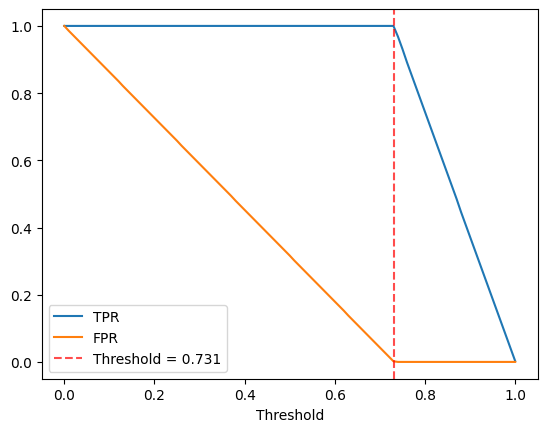

In [39]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')

plt.axvline(x=1-y_val.mean(), color='red', linestyle='--', alpha = 0.7, label=f'Threshold = {round(1-y_val.mean(),4)}')
plt.xlabel('Threshold')

plt.legend();

In the case of ideal model what do you think the accuracy would be? Well, you guessed them all correctly! 

Why do you think there is a ramp when it comes to FPR up to a point of cut-off probability? Because, starting at threshold>=0 you are saying that everything above that should be considered as churn, and given that you first sorted your ```y_preds``` such that we first get a portion of non-churning ones and then the churning ones, you would guess correctly all the churned ones all the time (up until cut-off threshold == 0.731) and thus you are introducing False Positives and they slowly (linearly) decrease. They reach their minimum at 0.731. Why TPR ramps down after cut-off==0.731? Think about that. 

--- 

Here is more stretch to that, how would you make threshold>=0 such that ```TPR==1``` and ```FPR==0```? Well, given that you have **a dataset where everybody churns** and you catch all True Positives. There are different cases for predicted probabilitites given that everyone churns:

1) They are >=0 be it random or something like we've discussed ex. linear trend, 

2) You set them all to be 1 (upper right corner we are striving towards). 

Is that model even realistic at any case? Imagine the company where everyone churns. You don't need any more realization than thinking that it got bankrupt. 

Here is how would you look at it.

**Note: The number of True Negatives would be 0 since there is nobody who churns, and dividing by zero gives you NaN. We will cheat a little and say `fpr==0`.**

In [40]:
num_pos = len(y_val)

y_ideal = np.repeat(1, num_pos)
y_ideal_pred = np.repeat(1.0, num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal['fpr'] = 0
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,1409,0,0,0,1.0,0
10,0.1,1409,0,0,0,1.0,0
20,0.2,1409,0,0,0,1.0,0
30,0.3,1409,0,0,0,1.0,0
40,0.4,1409,0,0,0,1.0,0
50,0.5,1409,0,0,0,1.0,0
60,0.6,1409,0,0,0,1.0,0
70,0.7,1409,0,0,0,1.0,0
80,0.8,1409,0,0,0,1.0,0
90,0.9,1409,0,0,0,1.0,0


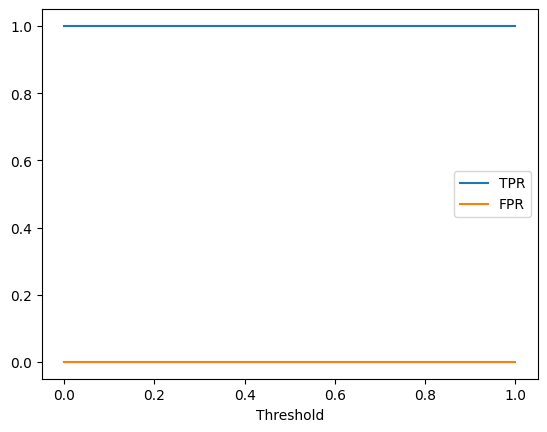

In [41]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')

plt.xlabel('Threshold')

plt.legend();

Is that model even realistic at any case? Imagine the company where everyone churns. You don't need any more realization than thinking it got bankrupt. 

Now, imagine the company where nobody churns. Well, you don't need any modeling at all. Your problems are solved. Copy the business model from them. 

## Worst-Case Scenario (Random Classifier)

We disscused a bit on the implications of ideal model, now we have to check the other extreme, worst-case scenario. Given that we know in what context TPR and FPR curves should 'strive' for can you think of the worst case scenario that could happen to us?

Say before you started modeling, you defined some sort of tolerance for TPR and FPR. We've covered the ideal case and their TPR/FPR graphs. We've covered the 'realistic case' for that matter. We've observed that the more they are divergent one from another the more freedom we have in choosing the right cut-off for our desired tolerance. 

In that matter, I would think that the worst possible case is *where both graphs converge towards one another* and they 'collapse' into diagonal line. Basically, given any threshold you would obtain the same TPR and FPR. They follow each other for each cut-off probability! Say you wanted `tpr_tolerance==0.6`. You've found the cut-off for that, but at the same time `fpr_tolerance==0.6` and you strive to minimize it! How in all of that TPR/FPR (roughly) following would you get to your desired state? The model that gives you such thing is basically useless. That is why it is the worst case scenario. 

Don't worry about the code for now, just take a look at the visualization:

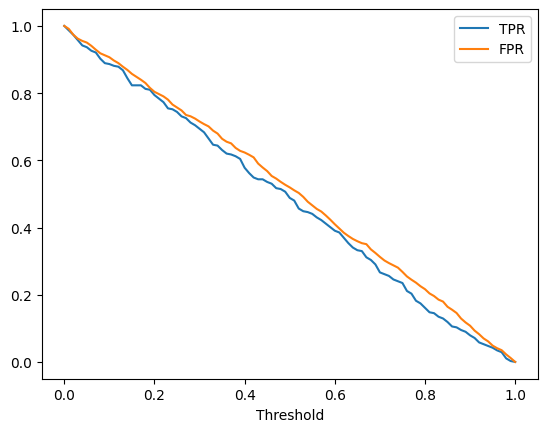

In [42]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

df_rand = tpr_fpr_dataframe(y_val, y_rand)

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.xlabel('Threshold')

plt.legend();

You see that both TPR and FPR graph are roughly following a diagonal line. That is because there is implicit randomness in the whole process.  But, why 'Random Classifier' has anything to do with 'the worst case scenario'? It was better than DummyModel which predicts all customers as churning. Poeple usually confuse this, but here we are checking TPR and FPR, not Accuracy. 

To get an intuitive feel for `RandomClassifier` we need to start simply. Detach from the idea of using `validation dataset` for now. 

Say we have extreme case where all the `y_preds` are 1. In deciding predicted values, we do a fair coin toss. 
Without any code, think why would half of them be correct and half of them don't. Let's simulate it.

In [43]:
head_weights = 50
tails_weights = 50

coin_toss(head_weights,50)

'Tails'

In [44]:
df_coin_toss['coin_toss_result'] = df_coin_toss.apply(lambda row: coin_toss(weight_heads=50, weight_tails=50), axis=1)
df_coin_toss['is_heads'] = df_coin_toss['coin_toss_result'].apply(lambda result: 1 if result == 'Heads' else 0)
df_coin_toss['correct'] = df_coin_toss.actual == df_coin_toss.is_heads

In [45]:
num_pos = len(y_val)

y_simulated = np.repeat(1, num_pos)
df_coin_toss = pd.DataFrame()

df_coin_toss['y_actual'] = y_simulated
df_coin_toss['coin_toss_result'] = df_coin_toss.apply(lambda row: coin_toss(weight_heads=50, weight_tails=50), axis=1)
df_coin_toss['is_heads'] = df_coin_toss['coin_toss_result'].apply(lambda result: 1 if result == 'Heads' else 0)

#If y_actual is 1 and is_heads is 1 then we have a correct prediction:
df_coin_toss['correct'] = df_coin_toss.y_actual == df_coin_toss.is_heads

In [46]:
df_coin_toss[::100]

,y_actual,coin_toss_result,is_heads,correct
0,1,Tails,0,False
100,1,Heads,1,True
200,1,Heads,1,True
300,1,Tails,0,False
400,1,Heads,1,True
500,1,Heads,1,True
600,1,Heads,1,True
700,1,Tails,0,False
800,1,Heads,1,True
900,1,Heads,1,True


We should expect that 50% of them are correct and 50% are wrong:

In [47]:
df_coin_toss.correct.mean()

0.49538679914833217

Since we have a dataset where all the customers are churning, and our options are (based on the fair coin toss) either 'churning' or 'no churning', we've explained portion for True Positives and False Negatives. We also see that they are equally likely to happen, because half of the dataset would be guessed right (True Positives), and the other half not (False Negatives). Keep that in mind. 

---

You think the size of the dataset influces it? Well, I am not going to say that if you have ten customers who are churning that you would obtain same results, but the more data you have the more will result converge to 50/50 (50% of TPs and 50% of FNs). This is very, very crucial to understand because we are dealing with the unbalanced dataset and one might think that 30/70, but we will talk about that a bit later! 

I will simulate the same process by doubling the size of `y_simulated`.

In [48]:
num_pos = 2*len(y_val)

y_simulated = np.repeat(1, num_pos)
df_coin_toss = pd.DataFrame()

df_coin_toss['y_actual'] = y_simulated
df_coin_toss['coin_toss_result'] = df_coin_toss.apply(lambda row: coin_toss(weight_heads=50, weight_tails=50), axis=1)
df_coin_toss['is_heads'] = df_coin_toss['coin_toss_result'].apply(lambda result: 1 if result == 'Heads' else 0)
df_coin_toss['correct'] = df_coin_toss.y_actual == df_coin_toss.is_heads

df_coin_toss.correct.mean()

0.5198722498225692

Again it is roughly 50%. 

> Size doesn't matter.

You think something different would happen with using 'uniform distribution' instead of my `coin_toss` simulation?

We've used `np.random.uniform(0, 1, size=len(y_val))` because it will give us some representation of probabilities, like we would expect the `LogisticRegression` model would give us. That is why are drawing samples from it on a range [0,1]. It is also a proxy for 'randomly generated probabilitites'. The x-axis represents 'probablities' and on the y-axis is how likely that you will get that probability. 

The fair coin toss is also an uniform distribution, so don't get scared! You should look at that line of code a bit differently and you will see that, in a nutshell, it is same like tossing a coin but helps us give better simulation of predicted probabilitites. 

Let's say we have an uniform distribution and point at x-axis 0.5 dictates our fair-coin toss in a sense: If you obtain the probability larger than that we will say it is heads, and conversely we will say it is tails. Since all of the probabilitites (points on x-axis) are equally likely it means that it is equally likely that we will have probability larger than 0.5 or probability smaller than 0.5. Same like coin toss, but different perspective! 

Slightly different code, but now we are using `np.random.uniform(0, 1, size=len(y_val))`: 

In [49]:
num_pos = len(y_val)

y_simulated = np.repeat(1, num_pos)
y_rand = np.random.uniform(0, 1, size=len(y_val))

df_coin_toss = pd.DataFrame()

df_coin_toss['y_actual'] = y_simulated
df_coin_toss['y_proba'] = y_rand

df_coin_toss.head()

,y_actual,y_proba
0,1,0.184906
1,1,0.526852
2,1,0.417102
3,1,0.800660
4,1,0.933202


As we've previously said 0.5 dictates our fair-coin toss experiment. 

In [50]:
df_coin_toss['is_heads'] = (df_coin_toss.y_proba >= 0.5)
df_coin_toss['correct'] = df_coin_toss.y_actual == df_coin_toss.is_heads

df_coin_toss.correct.mean()

0.49751596877217885

You see, nothing changed! For the exercise do all the same process by generating only non-churning customers. Then, you will explain the portion for True Negatives and False Positives. You will also get the same results in terms of the size of dataset, and given that you are using `coin_toss` function or `np.random.uniform`.

---

At this point you should have a feeling of how this all works. 

It is time to combine those two, one for churning ones and one for non-churning, into one *big* dataset and then we will apply fair-coin toss. Now, when you do the coin toss, not only that TPs and FNs are included, but also TNs and FPs.  It might sound a bit counter-intuitive when we combine those two that half of them will be correct and half don't. 

You can think of it like this: First I draw a portion of only churning customers, the `coin_toss` function will generate for each such customer a 'prediction' and we will obtain TPs and FNs. There is 50/50 of them. Now, I give them back to the dataset and draw the customers who are not churning. The `coin_toss` does it's magic again and we give it back to a dataset. Now we have TNs and FPs. All four of those are equally distributed if you think about that. At the end, 25% of True Positives and 25% of True Negatives constitute 50% of all predictions that are correct. That's it.

The fair coin toss doesn't care what features do you have. It doesn't even care about the actual values. Half of that whole, combined dataset would be right, and half of it wrong.

Now, that you are okay with that understand that it will only 'roughly' be that because of the randomness but given 'unlimited' data the TPR and FPR curves would converge to a diagonal. 

Again, let's put the same code above and give few more conclusions:

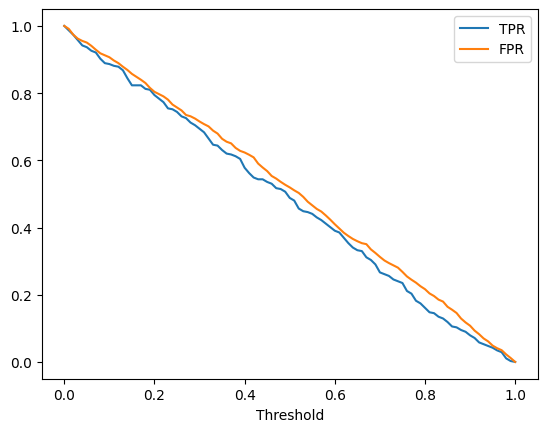

In [51]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

df_rand = tpr_fpr_dataframe(y_val, y_rand)

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.xlabel('Threshold')

plt.legend();

The trick is that coin-toss is 'binary' in nature, and so is our problem. That is why on some occasions it will have these cases 0 0 or 0 1 or 1 1 or 1 0. Say that we introduced another class '2', and you've simulated a coin-toss. Well, how would you interpret '2 0' or '2 1' with the respect to all other cases? The coin-toss doesn't work with multiclass, but you would naturally extend it such that there are three classes with equal probability of obtaining one. All the rest applies!

---

'So, why is changing threshold also changing TPRs and FPRs even if they follow the same diagonal?'

We assesed that distribution of TPs, FPs, TNs and FNs is the same, and as we've already discussed if one exits the set it must populate the other one ex. when FN gets out it will enter into TP's set and vice-versa! 

Also, because of the equal distribution of all fours (25%-25%-25%-25%), when you change the threshold you should expect that it will affect non-churning customers ex. when one TN get's out it will enter into FP set. 

That is why TPR and FPR are in a sense following each others. 

Think of it like this when you do a small increment in threshold:

\begin{equation}
\text{False Positive Rate} = \frac{\color{green}{\text{False Positives}} \color{blue}{+1}}{\color{green}{\text{False Positives}}\color{blue}{+1} + \color{red}{\text{True Negatives}}\color{blue}{-1}}
\end{equation}

\begin{equation}
\text{True Positive Rate} = \frac{\color{green}{\text{True Positives}}\color{blue}{+1}}{\color{green}{\text{True Positives}}\color{blue}{+1} + \color{red}{\text{False Negatives}}\color{blue}{-1}}
\end{equation}

Ploting TPR and FPR graphs for all thresholds is all nice and fine, but we would agree that we can't really eyeball the ideal TPR and FPR. How about ploting TPRs vs FPRs? We would lose information for threshold, but if you got up to this point you have a fairly good intuition how you should intrepret this next graph. 

I will use `scikit-learn` for that. 

In [52]:
from sklearn.metrics import roc_curve

In [53]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

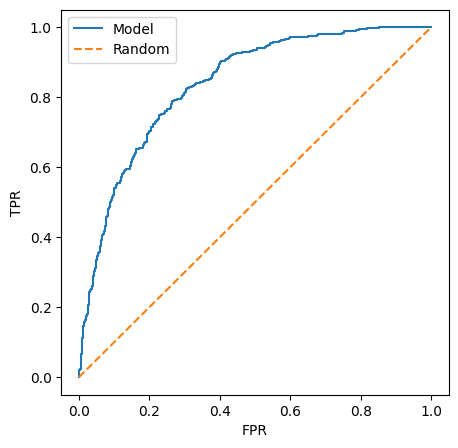

In [54]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

The result of a `roc_curve` is much more granular, because they've included more thresholds in their package.

Now, you can better see what to expect if you want to use particular TPR. The ideal model would be where `TPR==1` and `FPR==0`, so the top-left corner. You can also see that if you want for a particular TPR to get lower FPR you should strive to move all points on this graph diagonally under 45 degrees towards the top-left corner. The more you 'expand' it towards that corner, the better trade-off between TPR and FPR will be. 

Where are those threshold hiding? Can we intuit from this graph what is happening?

Start from the `TPR==0` and `FPR==0`. We've seen that, it's when we predicted that nobody is churning! It is the case where threshold>=1. Now, eyeball the `TPR==1` and `FPR==1`. Well, that is the case where we got all True Positives and at the same time catched all False Positives, so that should be when we set threshold>=0. 

Starting from the lowest point, up to the point with highest TPR and FPR we see that it resembles idea that the threshold is decreasing. As we keep decreasing the threshold we obtain much more True Positives and less and less False Positives. 


---

### Specificity

It is not discussed so far, but you will encounter explanations in a wild where ROC curves are drawn between TPR and Specificity.

Same like thinking about 'Recall' and 'True Positive Rate' can give you some kind of confusion, the name 'specificity' is in some sense synonymous with 'precision'. But, given the context of it's usage in medicine and how the metric is actually defined it can be made intuitive. 

In the context of medical testing and diagnosis, specificity is a critical metric that assesses the ability of a diagnostic test to correctly identify individuals without a particular condition or disease (true negatives). It is a measure of how well the test avoids false positives.

\begin{equation}
\text{Specificity} = \frac{\color{green}{\text{True Negatives}}}{\color{green}{\text{True Negatives}} + \color{red}{\text{False Positives}}}
\end{equation}

Specificity refers to **the ability of a test** to **specifically** identify individuals who do not have a particular condition, providing a precise and accurate negative result. It is about **being specific in the sense of correctly identifying the true negatives, which are individuals who do not have the condition being tested for**.

A high specificity indicates a low rate of false positives, meaning that the test is effective at correctly identifying individuals who do not have the condition. This is particularly important in medical contexts because false positives can lead to unnecessary anxiety, further invasive testing, and potentially harmful treatments.

> (When you come to a doctor) I know what Specificity is, but at this point I am too afraid to ask how good it is. 

No doubt, **Specificity** could be used in our case. Increasing True Negatives is essentialy the same as decreasing False Positives ("you give one, you recieve one"), so in a sense it will convey almost the same idea as FPR. Of course, if we get more True Negatives then we would save money by not sending promotional emails to customers that are satisfied with our service. But, watch out how you interpet those graphs! If you use Specificity VS TPR you want them both to be as high as possible! 


## F1 Score

\begin{equation}
F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\end{equation}

We know that Precision and Recall are in some sense 'exclusive', but when you focus on increasing both of them at the same time (combining them) they will help each other in the idea of striving towards perfect model.


Say we have a dataset and we 'detach' portion of dataset where there are only part of the instances **predicted as positive**. From there you can get only two cases True Positives and False Positives.

What we are left is the other portion of dataset where there are all instances **predicted as negative**. In the second portion you would get either True Negatives or False Negatives. 


Precision focuses on maximizing True Positives, whilst decreasing False Positives. The idea is that by increasing Precision it doesn't mean that we are 'converting' False Positives to a True Positives. Don't mix it with the idea of changing threshold! It just means that given all the instances that we are predicted as positive there are less and less False Positives. When `Precision==1` there are only True Positives in the dataset. No False Positives at all. But, what about the other portion of the dataset?

We are left with False Negatives and True Negatives. Even if `Recall` is not interested in True Negatives in some sense having more of them would also make the model more ideal. 

Given `Precision==1` it means that there are some number of True Positives and no False Positives whatsoever.
If we focused solely on the `Precision==1` then we would be left with part of the dataset where there are True Negatives and False Negatives. When you give a model to optimize for best possible Precision, you could be left with different number of True Negatives and False Negatives. Imagine that `Precision==1` covers only 30% of dataset. You could think in all different possible scenarios in which other part of the dataset has proportion of True Negatives and False Negatives. Let's think of the case where 70% of them are False Negatives. What do you think the Recall would be if we have 30% of True Positives and 70% of False Negatives?

Well I think it would be pretty bad, because Recall focuses on decreasing those! Yes, the Recall would be greater than 0 because in it's definition there are also True Positives,but there are also 70% of False Negatives. Such dataset would have Precision of 100%, but not the Recall. 

Conversely, let's now focus on the part of dataset where there are all instances predicted as negatives. The other part of the dataset would have different amount of True Positives and False Positives. Let's for an example think that there is at least one True Positive. The Recall would be maximum (`Recall == 1`) if among all the instances predicted as negatives there are all True Negatives. But it does not guarantee that Precision will be good. 

In both cases when there are no True Positives no matter if there are False Positives, False Negatives or True Negatives both Recall and Precision would be 0. Another fact is that those, so called 'portions' could have different amount of data! Keep that in mind, because F1 score is mainly used for unbalanced datasets. 


What if we combined Precision and Recall and in some sense give a model optimization task such that not only it should increase Precision, or Recall but we want both of them to be good. We would penalize the model if it only optimizes for maximizing one ex. Precision or Recall but not both. Not only that, but if in those 'portions' we have inbalance ex. 30%/70% and say we have `Precision==1` for those in 30%, then in the worse case scenario if we had 70% of False Negatives it would make Recall so small! We want to find such a method of combining those two such that when model encounters cases like we've explained it should say it is 'bad', and we should look for a better one. 

What would come to mind when we try to balance those two is taking a simple average like `1/2*(Precision + Recall)`. Looks good. We have to optimize for getting Precision and Recall be 1. In that case `(1+1)/2` would give maximum! 

But, how about these cases: `Precision==0.5 and Recall==0.5`, `Precision==0.8 and Recall==0.2`. Both of them would have the same simple average. Let's say for a moment that the best model got simple average of value 0.5. You should expect to get any of those case among others (ex. 0.9 and 0.1). You might obtain different results for the same average value! Not only that we don't want multitude of possibilites, but we also want to penalize the model that has a large disparity between Precision and Recall, encouraging a balance between the two metrics. When you make them close in score with one another, you are fixing the 'unbalanced' dataset problem.

ex. Say that we've predicted 10% of customers who churn, and 90% who didn't churn. Precision deals and improves the 10% and Recall those 90%. Imagine that Precision is 1 and Recall 0.2. You've essentially fixed all the True Positives but at the same time there are 80% of True Negatives. It would sound more intuitive if we proportionally had improved Precision and Recall. In both cases the same amount of TPs and TNs will be 'fixed'. If the `Precision==Recall==0.8` that means that we will 'fix' 80% of True Positives, whilst at the same time 'fix' 80% of True Negatives (because given `Recall==0.8` it would mean that out of all those who we predicted as non-churning we are left with 20% of False Negatives). 

Putting it all together, we also want that metric to give only good score when having balanced Precision and Recall, and all of the rest should have 'drastically' lower score (much penalization).


Welcome, F1 score!

\begin{equation}
F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\end{equation}

Look at that 'harmony' between Precision and Recall!

Note: To get the feeling of F1 score and try to give it different values for Precision and Recall. Start first with `Precision==Recall` cases, and then try cases like `Precision=0.8` and `Recall==0.1` etc.

---

Now we cleared out all the understandings, but how should we compare two models which has better ROC? Always drawing a picture? How about we sum everything into one number and from that we draw ROC curve and choose the optimal TPR and FPR for our case. Welcome, AUC score!


This one is relatively easy to interpret. You have a ROC curve which has bounds for x-axis [0,1] and same for the y-axis [0,1]. That is a square. **AUC** is abbreviation for **A**rea **U**nder the **C**urve. 

Given that we have a square there are two AUC scores which make obvious sense:

- The ideal model has `AUC == 1` because it is the area of whole square. 
- The worst-case model (Random Classifier) has `AUC==0.5` because having a diagonal line it splits the square into two parts.

Now, `AUC == 1` and `AUC==0.5` are our bounds for identifying how good a model is. The better the model, the more the AUC should be towards 1. Obviously, if we have two models then one which is closer to `AUC == 1` is better. 

But, for the first time in my life I learnt about different interpretation of AUC score, and it is beautiful.  

Given two subsets: churning customers (positive examples) and non-churning customers (negative examples), AUC measures a probability that randomly selected positive example (churned customer) will have higher score (predicted probability) than randomly selected negative example (non-churned customer). 

AUC = p[score(positive_example) > score(negative_example)]

It is also a measure of 'how well our model can orders customers'. Think of an ideal model, where there are progressively increasing probabilities from non-churning customers up to a churning ones. In that case given **any** random positive example it will have bigger predicted probability than any other randomly selected negative example. Well, in that case the probability of such event is 1. Hence, AUC is 1. 

You can also see from the definition of that there is some 'ordering' because of the meaning of >.

Going to the other extreme, Random Classifier gives roughly 25%-25%-25%-25% distribution for TPs, FNs, TNs and FPs you can see that if you randomly choose a positive example and get True Positive then surely it will be bigger than any other predicted probability. Intuitevely, True Positive guarantees you higher predicted probability and in an essence is more 'trustworthy' than for example False Negative. Again take a look at process of sampling from the uniform distribution: when it comes to the set of churned customers only and you get probability <0.5 it will generate False Negative. Conversely, if the probability is >0.5 we will generate True Positive. 

All of this will apply for the True Negatives. Given just True Positives and True Negatives as 

Well, you would say 'but the process for sampling from uniform distribution will also make False Positives larger sampled probabilitites'. Yes, that is also the case! But then, you have to shift your perspective to: there are 50% of sampled probabilitites larger than 0.5 (`combined dataset = churning + non-churning customers`), and 50% for the ones smaller than 0.5. 

In both cases 50% of them are correctly ordered and 50% of them are incorrectly ordered. Hence, AUC=0.5. 

You see how much time and details it took to explain such things? Imagine you are a Data Scientist who wants to explain to your stakeholders all of this (and they are as average as you and me!). Some people say that it is used in industry and others that it is not.